## Imports

In [1]:
import warnings 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy

from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
import itertools

from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [3]:
input = '../input/skin-cancer-mnist-ham10000/'
os.listdir(input)

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

## Create the directory structure

In [4]:
#Checks if the folder HAM10000_224new exists. If not, it creates the folder where augmented and processed images will be stored.

folders_to_create = ["Processed_file"]


def create_folders(folders):
    for folder in folders:
        folder_path = os.path.join(folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder '{folder}' doesnt exist.")
        else:
            print(f"Folder '{folder}' already exist.")


create_folders(folders_to_create)

Folder 'Processed_file' doesnt exist.


## Loading Metadata 

In [5]:
base = 'Processed_file'

data_pd = pd.read_csv(input+'HAM10000_metadata.csv')
data_pd.head()

train_dir = os.path.join(base, "train_dir")
test_dir = os.path.join(base, "test_dir")

## Grouping by lesion_id

In [6]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [7]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

## Identifying Duplicate Lesions:

In [8]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'
# Identifies whether a lesion appears more than once to prevent data leakage.
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [9]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

data_pd['is_duplicate'].value_counts()

no            5514
duplicates    4501
Name: is_duplicate, dtype: int64

## Mapping Lesion Types

In [10]:

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}

data_pd.dx=data_pd.dx.astype('category',copy=True)
data_pd['label']=data_pd.dx.cat.codes # Convert the labels to numbers
data_pd['lesion_type']= data_pd.dx.map(lesion_type_dict)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,label,lesion_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis-like lesions (bkl)
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis-like lesions (bkl)
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis-like lesions (bkl)
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis-like lesions (bkl)
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,2,Benign keratosis-like lesions (bkl)


In [11]:

class_counts = data_pd['lesion_type'].value_counts()
print(class_counts)

Melanocytic nevi (nv)                  6705
Melanoma (mel)                         1113
Benign keratosis-like lesions (bkl)    1099
Basal cell carcinoma (bcc)              514
Actinic keratoses (akiec)               327
Vascular lesions (vasc)                 142
Dermatofibroma (df)                     115
Name: lesion_type, dtype: int64


## Train/Test Split:

In [12]:
# #Split test data 20%
train, test_df = train_test_split(df_count, test_size=0.20, stratify=df_count['dx'])
#Splits the dataset into a training and test set using stratified sampling (ensuring equal class distribution)

In [13]:
#labels images as either part of the train or test set
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']

train_df.head()
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
5943,HAM_0002837,ISIC_0025859,nv,follow_up,50.0,female,back,no
5822,HAM_0001925,ISIC_0027583,nv,follow_up,45.0,male,trunk,no
4078,HAM_0001861,ISIC_0026688,nv,follow_up,70.0,male,unknown,no
5554,HAM_0000616,ISIC_0024750,nv,follow_up,50.0,male,trunk,no
4432,HAM_0007386,ISIC_0024568,nv,follow_up,40.0,male,lower extremity,no


In [14]:
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

print(len(train_list))
print(len(test_list))

8912
1103


In [15]:
data_pd.set_index('image_id', inplace=True)

## Creating Train and Test Directories

In [16]:
#these directories will store the training and testing images
os.mkdir(train_dir)
os.mkdir(test_dir)

In [17]:
# Creating Class-Specific Directories
classname = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for i in classname:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

# Listing Files in Input Directories
folder_1 = os.listdir(input+'ham10000_images_part_1')
folder_2 = os.listdir(input+'ham10000_images_part_2')

# Copying Images to Train Directory
for image in train_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(input+'ham10000_images_part_1', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(input+'ham10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)
        
# Copying Images to Test Directory
for image in test_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(input+'ham10000_images_part_1', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(input+'ham10000_images_part_2', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

# Class Counts in the Training Set
train_class_counts = train_df['lesion_type'].value_counts()
print("Train File Class Counts:")
print(train_class_counts)

Train File Class Counts:
Melanocytic nevi (nv)                  5822
Melanoma (mel)                         1067
Benign keratosis-like lesions (bkl)    1011
Basal cell carcinoma (bcc)              479
Actinic keratoses (akiec)               297
Vascular lesions (vasc)                 129
Dermatofibroma (df)                     107
Name: lesion_type, dtype: int64


## Data Augmentation

In [18]:

classname = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
for img_class in classname:
    # Creating Directories for Augmentation
    aug_dir = os.path.join(base, "aug_dir")
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, "img_dir")
    os.mkdir(img_dir)

    # Copying Images to Augmentation Directory
    img_list = os.listdir(
        os.path.join(base, "train_dir", img_class)
    )
    for file_name in img_list:
        source = os.path.join(
            base, "train_dir", img_class, file_name
        )
        target = os.path.join(img_dir, file_name)
        shutil.copyfile(source, target)

    # Setting Up Augmentation Parameters
    source_path = aug_dir
    save_path = os.path.join(base, "train_dir", img_class)
    batch_size = 50

    # Defining the Augmentation Process
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip = True
        #vertical_flip = True
    )
    
    # Generating and Saving Augmented Images
    aug_datagen = datagen.flow_from_directory(
        source_path,
        save_to_dir=save_path,
        save_format="jpg",
        target_size=(224, 224),
        batch_size=batch_size,
    )

    # Determining Number of Batches for Augmentation
    aug_images = 6000
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # Generating the Augmented Images
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # Cleaning Up Temporary Directories
    shutil.rmtree(aug_dir)

Found 297 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 107 images belonging to 1 classes.
Found 1067 images belonging to 1 classes.
Found 5822 images belonging to 1 classes.
Found 129 images belonging to 1 classes.


In [19]:
# counts and prints the number of images per class in the augmented training dataset
def count_images_per_class(directory):
    class_counts = {}

    for img_class in os.listdir(directory):
        class_path = os.path.join(directory, img_class)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[img_class] = num_images

    return class_counts

# counts and prints the number of images per class in the augmented training dataset
augmented_train_dir = os.path.join(base, "train_dir")

augmented_class_counts = count_images_per_class(augmented_train_dir)

print("Train samples for each class:")

for img_class, count in augmented_class_counts.items():
    print(f"{img_class}: {count} images")

Train samples for each class:
bkl: 5855 images
akiec: 5990 images
bcc: 5798 images
nv: 6022 images
mel: 5885 images
vasc: 5210 images
df: 4330 images


In [20]:
# count each class samples from test data
test_class_counts = test_df["dx"].value_counts()

print("Test samples for each class:")
print(test_class_counts)

Test samples for each class:
nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64


# Training Model

In [21]:
train_path = '/kaggle/working/Processed_file/train_dir'
test_path = '/kaggle/working/Processed_file/test_dir'

batch_size = 32
image_size = 224

In [87]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

# Data Augmentation with Xception's preprocessing function
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size, image_size),
                                            batch_size=batch_size, shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                           target_size=(image_size, image_size),
                                           batch_size=batch_size, shuffle=False)


Found 39090 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [88]:
# Xception model
base_xception = Xception(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

# Freezing the Xception base layers
for layer in base_xception.layers:
    layer.trainable = False

# Custom Head for Xception
model = Sequential()
model.add(base_xception)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(7, activation="softmax"))

model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_220 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout_28 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_221 (Bat (None, 256)               1024      
_______________________________________________________

## compiling model

In [89]:
# Compile the model
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Callbacks
Callbacks = [ModelCheckpoint(filepath="xception_aug.hdf5", monitor="val_loss", save_best_only=True, verbose=1, mode="min"),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_lr=0.00000000001),
             EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)]

# Training the model
history = model.fit(
    train_batches,
    steps_per_epoch=(len(train_df) // batch_size),
    epochs=40,
    verbose=1,
    validation_data=test_batches,
    validation_steps=(len(test_df) // batch_size),
    callbacks=Callbacks
)

Epoch 1/40
278/278 [==============================] - 43s 144ms/step - loss: 1.4177 - accuracy: 0.4961 - val_loss: 0.5880 - val_accuracy: 0.8208

Epoch 00001: val_loss improved from inf to 0.58800, saving model to xception_aug.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
278/278 [==============================] - 40s 142ms/step - loss: 1.1088 - accuracy: 0.5950 - val_loss: 0.4806 - val_accuracy: 0.8511

Epoch 00002: val_loss improved from 0.58800 to 0.48058, saving model to xception_aug.hdf5
Epoch 3/40
278/278 [==============================] - 39s 141ms/step - loss: 1.0758 - accuracy: 0.6014 - val_loss: 0.4895 - val_accuracy: 0.8401

Epoch 00003: val_loss did not improve from 0.48058
Epoch 4/40
278/278 [==============================] - 39s 142ms/step - loss: 1.0085 - accuracy: 0.6250 - val_loss: 0.4673 - val_accuracy: 0.8539

Epoch 00004: val_loss improved from 0.48058 to 0.46733, saving model to xception_aug.hdf5
Epoch 5/40
278/278 [==============================] - 39s 140ms/step - loss: 0.9561 - accuracy: 0.6412 - val_loss: 0.4643 - val_accuracy: 0.8493

Epoch 00005: val_loss improved from 0.46733 to 0.46432, saving model to xception_aug.hdf5
Epoch 6/40
278/278 [==============================] - 40s 142ms/step - loss: 0.9489 - accuracy:

In [90]:
# Save the trained model
model.save("xception_aug.hdf5")


In [91]:
# Evaluate the model on the test set
test_score = model.evaluate(test_batches, verbose=1)

print("Test loss: ", test_score[0])
print("Test acc: ", test_score[1])

35/35 [==============================] - 10s 288ms/step - loss: 0.4303 - accuracy: 0.8631
Test loss:  0.43030112981796265
Test acc:  0.8631006479263306


34/34 [==============================] - 10s 281ms/step

Classification Report:
               precision    recall  f1-score   support

       akiec    0.40000   0.33333   0.36364        30
         bcc    0.53333   0.45714   0.49231        35
         bkl    0.55696   0.50000   0.52695        88
          df    1.00000   0.25000   0.40000         8
         mel    0.57143   0.34783   0.43243        46
          nv    0.92034   0.96829   0.94371       883
        vasc    0.90000   0.69231   0.78261        13

    accuracy                        0.86310      1103
   macro avg    0.69744   0.50699   0.56309      1103
weighted avg    0.85071   0.86310   0.85319      1103



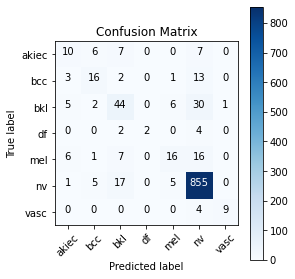

In [92]:
# Get the class labels from the training batches
classname_label = list(train_batches.class_indices.keys())

# True labels from the test set
true_labels = test_batches.classes

# Load the saved model weights
model.load_weights("xception_aug.hdf5")

# Predict the labels on the test set
predictions = model.predict(test_batches, steps=len(test_df) / batch_size, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=classname_label, digits=5)
print("\nClassification Report:\n", class_report)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Set tick marks and labels
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

# Add text annotations
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j, i, conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black"
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

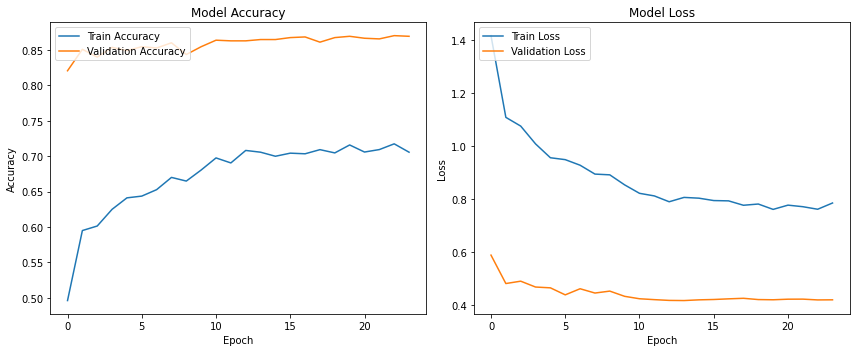

In [93]:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

34/34 [==============================] - 10s 281ms/step


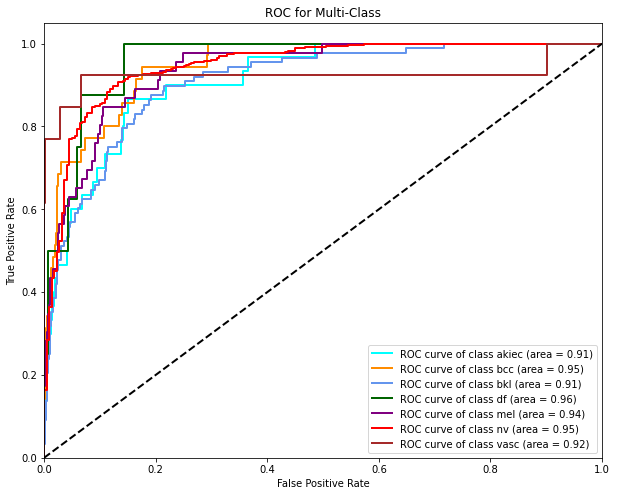

In [94]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# Get the class labels from the training batches
classname_label = list(train_batches.class_indices.keys())

# True labels from the test set (one-hot encoded)
true_labels = test_batches.classes
true_labels_bin = label_binarize(true_labels, classes=np.arange(len(classname_label)))

# Predicted probabilities
predictions = model.predict(test_batches, steps=len(test_df) / batch_size, verbose=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classname_label)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple', 'red', 'brown'])
for i, color in zip(range(len(classname_label)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(classname_label[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Multi-Class')
plt.legend(loc="lower right")
plt.show()


## Inference time 

In [95]:
import time
import numpy as np

# Select one sample from the test set
single_sample = test_batches.next()[0][0]  # [0][0] selects the first image of the batch

# Reshape the sample to match the input shape expected by the model (batch size of 1)
single_sample = np.expand_dims(single_sample, axis=0)

# Measure the inference time
start_time = time.time()
prediction = model.predict(single_sample)
end_time = time.time()

# Calculate the elapsed time
inference_time = end_time - start_time

print(f"Inference time for 1 sample: {inference_time:.4f} seconds")

Inference time for 1 sample: 0.7837 seconds


## Model size

In [96]:
# Calculate model size in memory
def get_model_size(model):
    total_params = model.count_params()
    # Each parameter typically takes up 4 bytes (float32)
    model_size = total_params * 4 / (1024 * 1024)  # Convert to MB
    return model_size

size_in_memory_mb = get_model_size(model)
print(f"Model size in memory: {size_in_memory_mb:.2f} MB")


Model size in memory: 81.68 MB


In [97]:
import os

model_size = os.path.getsize('/kaggle/working/xception_aug.hdf5')  # Size in bytes
model_size_mb = model_size / (1024 * 1024)  # Convert to megabytes

print(f"Model size: {model_size_mb:.2f} MB")

Model size: 86.15 MB
